In [1]:
import csv
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pickle

Using TensorFlow backend.


In [2]:
DS = pd.read_csv("ObjectSubset150SentenceLength.csv")

In [3]:
len(DS)

157280

In [4]:
DS = DS[:10000]

In [5]:
DS['tag'].fillna('text', inplace=True)

In [6]:
DS.head()

,text_ID,word,tag
0,46809,RR,object
1,46809,130/80,object
2,46809,mmHg.,text
3,47482,"RR142/89mmHg,",object
4,47482,HR,text


In [7]:
words = list(set(DS["word"].values))
n_words = len(words);n_words

3657

In [8]:
tags = list(set(DS["tag"].values))
n_tags = len(tags); n_tags


2

In [9]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(),
                                                           s["tag"].values.tolist())]
        self.grouped = self.data.groupby("text_ID").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [10]:
getter = SentenceGetter(DS)

In [11]:
sentences = getter.sentences

In [12]:
len(sentences)

1085

In [13]:
sentences[1]

[('Pt.', 'text'),
 ('tehtud', 'text'),
 ('3', 'text'),
 ('plasmaferees,', 'text'),
 ('talus', 'text'),
 ('hästi.', 'text'),
 ('Eemaldatud', 'text'),
 ('700', 'text'),
 ('ml', 'text'),
 ('plasmat.', 'text'),
 ('RR', 'object'),
 ('112/60', 'object'),
 ('mmHg.', 'text'),
 ('Tgasi', 'text'),
 ('22.10.09.', 'text')]

In [14]:
max_len = 10
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["O"] = 0


In [15]:
X = [[w[0] for w in s] for s in sentences]


In [16]:
new_X = []
for seq in X:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("__PAD__")
    new_X.append(new_seq)
X = new_X

In [17]:
print(X[1])

['Pt.', 'tehtud', '3', 'plasmaferees,', 'talus', 'hästi.', 'Eemaldatud', '700', 'ml', 'plasmat.']


In [18]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]


In [19]:
from keras.preprocessing.sequence import pad_sequences
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])


In [20]:
tag2idx

{'object': 1, 'text': 2, 'O': 0}

In [21]:
idx2tag = {i: w for w, i in tag2idx.items()}

In [22]:
idx2tag

{1: 'object', 2: 'text', 0: 'O'}

In [23]:
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.6, random_state=2018)


In [24]:
len(X_tr)

434

In [25]:
batch_size = 32


In [26]:
# import tensorflow.compat.v1 as tf
# from keras import backend as K

# # import tensorflow_hub as hub
# # from keras import backend as K
# # sess = tf.Session()

# # init = tf.global_variables_initializer() # This reinitializes keras weights, so must be put before Keras loading
# sess.run(init)
# sess.run(tf.global_variables_initializer())
# K.set_session(sess)

import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K


In [28]:
from allennlp.modules.elmo import Elmo, batch_to_ids
options_file = "options.json"
weight_file = "swb_weights.hdf5"
elmo_model  = Elmo(options_file, weight_file, 2, dropout=0)


In [120]:
from allennlp.modules.elmo import Elmo, batch_to_ids, Vocabulary, ELMoCharacterMapper


In [131]:
elmo_model

Elmo(
  (_elmo_lstm): _ElmoBiLm(
    (_token_embedder): _ElmoCharacterEncoder(
      (char_conv_0): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
      (char_conv_1): Conv1d(16, 32, kernel_size=(2,), stride=(1,))
      (char_conv_2): Conv1d(16, 64, kernel_size=(3,), stride=(1,))
      (char_conv_3): Conv1d(16, 128, kernel_size=(4,), stride=(1,))
      (char_conv_4): Conv1d(16, 256, kernel_size=(5,), stride=(1,))
      (char_conv_5): Conv1d(16, 512, kernel_size=(6,), stride=(1,))
      (char_conv_6): Conv1d(16, 1024, kernel_size=(7,), stride=(1,))
      (_highways): Highway(
        (_layers): ModuleList(
          (0): Linear(in_features=2048, out_features=4096, bias=True)
          (1): Linear(in_features=2048, out_features=4096, bias=True)
        )
      )
      (_projection): Linear(in_features=2048, out_features=512, bias=True)
    )
    (_elmo_lstm): ElmoLstm(
      (forward_layer_0): LstmCellWithProjection(
        (input_linearity): Linear(in_features=512, out_features=16384, b

In [51]:
# import tensorflow_hub as hub 


In [41]:
# # tf.disable_eager_execution()

# elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)


In [48]:
# from keras.models import Model, Input
# from keras.layers.merge import add
# from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda


In [29]:
X_tr_character_ids = batch_to_ids(X_tr)
X_tr_embeddings = elmo_model(X_tr_character_ids)

X_te_character_ids = batch_to_ids(X_te)
X_te_embeddings = elmo_model(X_te_character_ids)

In [47]:
# sess.run(tf.compat.v1.global_variables_initializer())
# sess.run(tf.compat.v1.tables_initializer())

In [45]:
# def ElmoEmbedding(x):
#     return elmo_model(inputs={
#                             "tokens": tf.squeeze(tf.cast(x, tf.string)),
#                             "sequence_len": tf.constant(batch_size*[max_len])
#                       },
# #                       signature="tokens",
#                       as_dict=True)["elmo"]


In [30]:
# from keras.models import Model, Input
# from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda


In [51]:
# input_text = Input(shape=(max_len,), dtype=tf.string)
# embedding = Lambda(ElmoEmbedding, output_shape=(None, 1024))(input_text)
# x = Bidirectional(LSTM(units=512, return_sequences=True,
#                        recurrent_dropout=0.2, dropout=0.2))(embedding)
# x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
#                            recurrent_dropout=0.2, dropout=0.2))(x)
# x = add([x, x_rnn])  # residual connection to the first biLSTM
# out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)


In [31]:
X_tr_embeddings["elmo_representations"][1].shape

torch.Size([434, 10, 1024])

In [32]:
y_tr.shape

(434, 10)

In [34]:
n_tags

2

In [36]:
# y_te.reshape(217,10,1).shape

In [102]:
from keras.models import Sequential
from keras.layers import LSTM, core, Activation, Dense
import numpy as np
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D


model = Sequential()          

model.add(LSTM(50, input_shape=(10, 1024), return_sequences=True,recurrent_dropout=0.6))
# , dropout=0.2
model.add(TimeDistributed(Dense(3, activation='softmax')))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [98]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 150, 50)           215000    
_________________________________________________________________
time_distributed_16 (TimeDis (None, 150, 3)            153       
Total params: 215,153
Trainable params: 215,153
Non-trainable params: 0
_________________________________________________________________


In [99]:
# X_tr_embeddings['elmo_representations'][1].detach().numpy().shape

In [100]:
# y_tr.reshape(868,10,1)

In [103]:
history = model.fit(X_tr_embeddings['elmo_representations'][1].detach().numpy(), y_tr.reshape(y_tr.shape[0],10,1),validation_split=0.1 ,verbose=1,epochs=10,batch_size=32)

Train on 390 samples, validate on 44 samples
Epoch 1/10
390/390 [==============================] - 1s 1ms/step - loss: 0.4873 - accuracy: 0.8472 - val_loss: 0.2413 - val_accuracy: 0.9295
Epoch 2/10
390/390 [==============================] - 0s 456us/step - loss: 0.2056 - accuracy: 0.9315 - val_loss: 0.1891 - val_accuracy: 0.9455
Epoch 3/10
390/390 [==============================] - 0s 459us/step - loss: 0.1668 - accuracy: 0.9379 - val_loss: 0.1759 - val_accuracy: 0.9386
Epoch 4/10
390/390 [==============================] - ETA: 0s - loss: 0.1475 - accuracy: 0.94 - 0s 456us/step - loss: 0.1468 - accuracy: 0.9449 - val_loss: 0.1758 - val_accuracy: 0.9523
Epoch 5/10
390/390 [==============================] - 0s 451us/step - loss: 0.1342 - accuracy: 0.9477 - val_loss: 0.1698 - val_accuracy: 0.9477
Epoch 6/10
390/390 [==============================] - 0s 421us/step - loss: 0.1216 - accuracy: 0.9500 - val_loss: 0.1669 - val_accuracy: 0.9500
Epoch 7/10
390/390 [==============================]

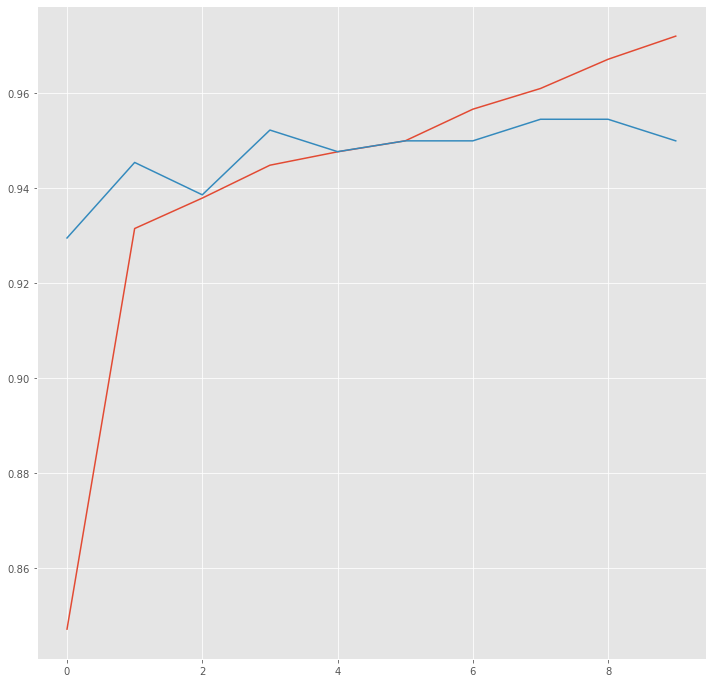

In [104]:
hist = pd.DataFrame(history.history)
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.show()


In [105]:
y_pred = model.predict(X_te_embeddings['elmo_representations'][1].detach().numpy(),verbose=1)

651/651 [==============================] - 0s 224us/step


In [106]:
y_pred[1]

array([[2.9279480e-03, 2.2904875e-02, 9.7416717e-01],
       [5.8955308e-03, 8.2393378e-01, 1.7017078e-01],
       [6.3151452e-03, 5.7540238e-01, 4.1828248e-01],
       [1.7276158e-03, 1.3815437e-02, 9.8445696e-01],
       [4.5477566e-03, 1.9985691e-02, 9.7546661e-01],
       [9.8784900e-01, 3.5014488e-03, 8.6495522e-03],
       [9.9598807e-01, 1.1015098e-03, 2.9104827e-03],
       [9.9722505e-01, 7.6261768e-04, 2.0123480e-03],
       [9.9768746e-01, 6.4733950e-04, 1.6652371e-03],
       [9.9783081e-01, 5.9194519e-04, 1.5772361e-03]], dtype=float32)

In [107]:
y_te[1]

array([2, 1, 1, 2, 2, 0, 0, 0, 0, 0])

In [108]:
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p, axis=-1)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out
pred_labels = pred2label(y_pred)

def pred2labelV2(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p])
        out.append(out_i)
    return out
test_labels = pred2labelV2(y_te)

In [176]:
i = 208
p = np.argmax(y_pred[i], axis=-1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_te[i], y_te[i], p):
    if w != 0:
        print("{:15}: {:5} {}".format(w,idx2tag[t], idx2tag[pred]))


Word           ||True ||Pred
*              : text  text
Psüühiline     : text  text
seisund        : text  text
normis         : text  text
__PAD__        : O     O
__PAD__        : O     O
__PAD__        : O     O
__PAD__        : O     O
__PAD__        : O     O
__PAD__        : O     O


In [178]:
j = 0
for i in range(len(y_pred)):
    p = np.argmax(y_pred[i], axis=-1)
#     print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
#     print(30 * "=")
    for w, t, pred in zip(X_te[i], y_te[i], p):
        if w != "__PAD__": #PAD
            if idx2tag[t] != idx2tag[pred]:
                print("{:15}: {:5} {}".format(w, idx2tag[t], idx2tag[pred]))
                j = j+1


101            : object text
kg,165         : object text
RR             : text  object
l/min.         : object text
RR             : object text
type="per"     : object text
ole.Toonid     : object text
tuhmid         : object text
Pikkus         : object text
127/67mmHg     : object text
norm,          : object text
kõht           : object text
,nüüd          : object text
RR             : object text
RR             : text  object
RR             : object text
160/100mm      : object text
RR-121/84      : object text
enesetunne     : object text
hea,           : object text
väärtus        : object text
RR             : object text
Cor            : object text
ole            : object text
RR             : object text
RR             : object text
160/90         : object text
eemaldatud     : object text
700            : object text
RR             : object text
140/           : object text
puhtad,        : object text
reg.           : object text
-              : object text
Cor         

In [179]:
j

329

In [163]:
from  sklearn_crfsuite.metrics import flat_classification_report  
report = flat_classification_report(y_pred=pred_labels, y_true=test_labels)
print(report)

              precision    recall  f1-score   support

           O       1.00      1.00      1.00      2181
      object       0.79      0.46      0.58       495
        text       0.93      0.98      0.96      3834

    accuracy                           0.95      6510
   macro avg       0.91      0.82      0.85      6510
weighted avg       0.94      0.95      0.94      6510



In [164]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 62.5%


In [165]:
print(classification_report(test_labels, pred_labels))

           precision    recall  f1-score   support

     text       0.70      0.63      0.66       816
   object       0.63      0.42      0.50       294

micro avg       0.69      0.57      0.63      1110
macro avg       0.69      0.57      0.62      1110



In [180]:
# sentences = [['minu', 'nimi' ,'on', 'nesma', 'hästi', 'Eemaldatud', '700', 'ml', 'plasmat','RR',' 112/60',' mmHg'], ['Pt.', 'tehtud' ,'plasmaferees', 'talus', 'hästi']]
# character_ids = batch_to_ids(sentences)
# embeddings = elmo_model(character_ids)

In [115]:
# embeddings['elmo_representations'][1].shape

torch.Size([2, 12, 1024])

In [116]:
# embeddings['elmo_representations'][1][1][4].detach().numpy()

array([ 1.5760477, -1.4664712,  1.4634519, ..., -1.5398364, -1.3632509,
        0.5512005], dtype=float32)

In [118]:
# scipy.spatial.distance.cosine(embeddings['elmo_representations'][1][1][4].detach().numpy(),embeddings['elmo_representations'][1][1][1].detach().numpy())